In [75]:
print("Starting imports...")
import sys
import os
import socket 
socket.setdefaulttimeout(1800)       

import numpy as np
import matplotlib.pyplot as plt
from numba import cuda, float64, complex128
from numba.cuda import jit as cuda_jit
import math

print("Importing few...")
import few
print(f"FEW location: {few.__file__}")


from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum 

from few.utils.ylm import GetYlms
from few import get_file_manager
from few.waveform import FastKerrEccentricEquatorialFlux, GenerateEMRIWaveform
from few.utils.geodesic import get_fundamental_frequencies
from few.utils.constants import *

print("Configuring few...")
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info")

Starting imports...
Importing few...
FEW location: /nfs/home/svu/e1498138/localgit/FEW_SM/FastEMRIWaveforms/src/few/__init__.py
Configuring few...


In [76]:
few.utils.modeselector.__file__

'/nfs/home/svu/e1498138/localgit/FEW_SM/FastEMRIWaveforms/src/few/utils/modeselector.py'

In [77]:
for backend in ["cpu", "cuda11x", "cuda12x", "cuda", "gpu"]: 
    print(f" - Backend '{backend}': {"available" if few.has_backend(backend) else "unavailable"}")  

 - Backend 'cpu': available
 - Backend 'cuda11x': unavailable
 - Backend 'cuda12x': available
 - Backend 'cuda': available
 - Backend 'gpu': available


In [78]:
use_gpu = True
force_backend = "cuda12x"  
print("Setting up waveform generator...")
# keyword arguments for inspiral generator 
inspiral_kwargs={
        "func": 'KerrEccEqFlux',
        "DENSE_STEPPING": 0, #change to 1/True for uniform sampling
        "include_minus_m": True, 
        "use_gpu" : use_gpu,
        "force_backend":force_backend
}

# keyword arguments for inspiral generator 
amplitude_kwargs = {
    "force_backend": force_backend,
    # "use_gpu" : use_gpu
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "force_backend": force_backend,
    # "assume_positive_m": True  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "force_backend":force_backend,
    "pad_output": True,
    # "separate_modes": True
    # "use_gpu" : use_gpu
}

print("Creating GenerateEMRIWaveform class...")
# # Kerr eccentric flux
# waveform_gen = FastKerrEccentricEquatorialFlux(
#     inspiral_kwargs=inspiral_kwargs,
#     amplitude_kwargs=amplitude_kwargs,
#     Ylm_kwargs=Ylm_kwargs,
#     sum_kwargs=sum_kwargs,
#     use_gpu=use_gpu,
# )

waveform_gen = GenerateEMRIWaveform(
    FastKerrEccentricEquatorialFlux, 
    frame='detector',
    inspiral_kwargs=inspiral_kwargs, 
    amplitude_kwargs=amplitude_kwargs, 
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu
)

Setting up waveform generator...
Creating GenerateEMRIWaveform class...


In [79]:
fast_kerr = FastKerrEccentricEquatorialFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,)

In [231]:
# Generating data (true)

m1 = 1.5e6
m2 = 1.5e1
a = 0.5
p0 = 5
e0 = 0.2
xI0 = 1.0
dist = 10 
qS = 1.0
phiS = 0.5 
qK = 2.0 
phiK = 1.0 
Phi_phi0 = 10.0
Phi_theta0 = 0.0 
Phi_r0 = 10.0
dt=10

In [232]:
# specific_modes =  [(2,2,0), (2,-2,0), (2,1,0), (2,-1,0)]
# # [(2, m, 0) for m in range(-2,3)]
# specific_modes

In [233]:
h_modes = waveform_gen(
    m1, 
    m2,
    a, 
    p0, 
    e0, 
    xI0, 
    dist,
    qS, 
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0, 
    dt=dt, 
    T=0.25, 
    # mode_selection=specific_modes, 
    include_minus_mkn=True
)

#waveform_gen(m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0, T=self.T, dt=self.dt)


In [234]:
h_modes

array([5.62667484e-24-2.52106120e-23j, 1.08578804e-23-2.12626507e-23j,
       1.51393465e-23-1.64507491e-23j, ...,
       0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
       0.00000000e+00+0.00000000e+00j])

In [235]:
# Initialize parameters and backend
N_traj = 500
use_gpu = True 
T = 0.25 # year
T_sec = T * YRSID_SI
dt = 10
delta_T = T_sec / N_traj # define coarser sampling time step

In [236]:
delta_T, T

(15779.074881772798, 0.25)

In [237]:
# Waveform generation attributes
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu, npoints = N_traj) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

In [238]:
def get_viewing_angles(qS, phiS, qK, phiK):
    cqS = np.cos(qS)
    sqS = np.sin(qS)
    cphiS = np.cos(phiS)
    sphiS = np.sin(phiS)
    cqK = np.cos(qK)
    sqK = np.sin(qK)
    cphiK = np.cos(phiK)
    sphiK = np.sin(phiK)

    # sky location vector
    R = np.array([sqS * cphiS, sqS * sphiS, cqS])
    # spin vector
    S = np.array([sqK * cphiK, sqK * sphiK, cqK])

    phi = -np.pi / 2.0
    theta = np.arccos(-np.dot(R, S))

    return (theta, phi)

In [239]:
theta, phi = get_viewing_angles(qS, phiS, qK, phiK)

In [240]:
import cupy as cp

In [241]:


# Generate trajectory WITH initial phases
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(
    m1, m2, a, p0, e0, xI0,
    T=0.25, dt=dt,
    Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0  # Pass the phases!
)

ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

# get amplitudes
teuk_modes = amp(a, p, e, x)

# need to prepare arrays for sum with all modes due to +/- m setup
ls = amp.l_arr[: teuk_modes.shape[1]]
ms = amp.m_arr[: teuk_modes.shape[1]]
ns = amp.n_arr[: teuk_modes.shape[1]]

keep_modes = np.arange(teuk_modes.shape[1])
temp2 = keep_modes * (keep_modes < amp.num_m0) + (keep_modes + amp.num_m_1_up) * (
    keep_modes >= amp.num_m0
) # amp.num_m0 gives number of modes with m == 0, amp.num_m_1_up gives number of modes with m > 0

ylmkeep = np.concatenate([keep_modes, temp2])
ylms_in = ylms[ylmkeep]
teuk_modes_in = teuk_modes

phase_coeff = traj.integrator_spline_phase_coeff[:, [0, 2], :].copy()  # 3D!
# Apply spin correction for retrograde orbits
if a > 0:
    phase_coeff[:, 0] *= np.sign(xI0)  # Phi_phi correction

# perform summation
waveform1 = interpolate_mode_sum(
    cp.asarray(t),
    teuk_modes_in,
    ylms_in,
    traj.integrator_spline_t,
    phase_coeff,
    ls,
    ms,
    ns,
    dt=dt,
    T=T,
)

In [242]:
mu = m1 * m2 / (m1 + m2)

dist_dimensionless = (dist * Gpc) / (mu * MRSUN_SI)

In [243]:
mu,dist_dimensionless

(14.999850001499984, 1.3931356337497417e+22)

In [244]:
dt, T

(10, 0.25)

In [245]:
waveform2 = fast_kerr(m1, m2, a, p0, e0, xI0, theta, phi, dist=dist, dt=dt, T=T)

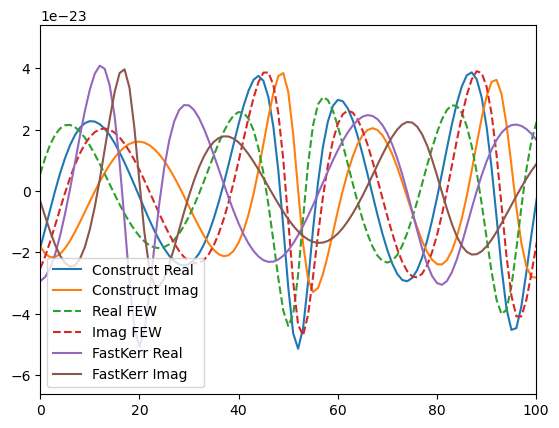

In [246]:
plt.plot(waveform1.get().real /dist_dimensionless, label="Construct Real")
plt.plot(waveform1.get().imag/dist_dimensionless, label="Construct Imag")
plt.plot(h_modes.get().real, label="Real FEW", linestyle='dashed')
plt.plot(h_modes.get().imag, label="Imag FEW", linestyle='dashed')
plt.plot(waveform2.get().real  , label="FastKerr Real")
plt.plot(waveform2.get().imag  , label="FastKerr Imag")
plt.xlim(0,100)
plt.legend(loc="lower left")

waveform constructed = fastkerr * dist

# For. detector. frame

In [247]:


def to_SSB_frame( hp, hc, qS, phiS, qK, phiK):
    """Transform to SSB frame"""

    cqS = np.cos(qS)
    sqS = np.sin(qS)

    # cphiS = np.cos(phiS)
    # sphiS = np.sin(phiS)

    cqK = np.cos(qK)
    sqK = np.sin(qK)

    # cphiK = np.cos(phiK)
    # sphiK = np.sin(phiK)

    # get polarization angle

    up_ldc = cqS * sqK * np.cos(phiS - phiK) - cqK * sqS
    dw_ldc = sqK * np.sin(phiS - phiK)

    if dw_ldc != 0.0:
        psi_ldc = -np.arctan2(up_ldc, dw_ldc)

    else:
        psi_ldc = 0.5 * np.pi

    c2psi_ldc = np.cos(2.0 * psi_ldc)
    s2psi_ldc = np.sin(2.0 * psi_ldc)

    # rotate
    FplusI = c2psi_ldc
    FcrosI = -s2psi_ldc
    FplusII = s2psi_ldc
    FcrosII = c2psi_ldc

    hp_new = FplusI * hp + FcrosI * hc
    hc_new = FplusII * hp + FcrosII * hc

    return hp_new, hc_new

In [257]:
hp_source = (waveform1.get().real / dist_dimensionless) *-1
hc_source = waveform1.get().imag / dist_dimensionless 

In [258]:
hp_detector, hc_detector = to_SSB_frame(hp_source, hc_source, qS, phiS, qK, phiK)

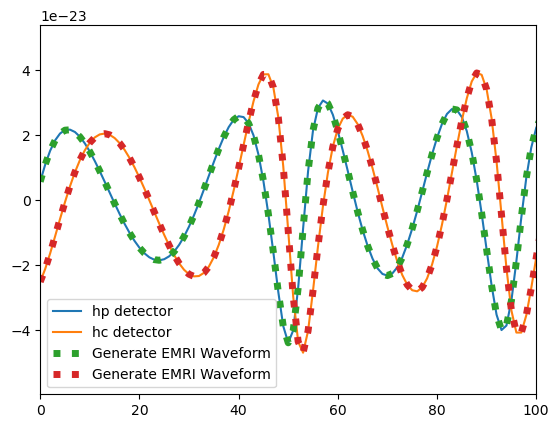

In [259]:
plt.plot(hp_detector, label="hp detector")
plt.plot(-hc_detector, label="hc detector")
plt.plot(h_modes.get().real, label="Generate EMRI Waveform", linestyle='dotted', linewidth=5)
plt.plot(h_modes.get().imag, label="Generate EMRI Waveform", linestyle='dotted', linewidth=5)
plt.xlim(0,100)
plt.legend(loc="lower left")
plt.show()